In [1]:
import pandas as pd

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head()

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [3]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [5]:
news[news['doc_id'].isin([293672, 293328, 293001, 293622, 293126, 1852])]

,doc_id,title
6615,293001,Группа «Алиса» отменила все концерты на Украин...
6740,293126,"В МИД нашли характеристику, данную агентством ..."
6942,293328,Актриса Джессика Биль открывает собственную ко...
7236,293622,Звезды Бродвея в преддверии сочинской Олимпиад...
7286,293672,Кинотеатр «Художественный» откроется после рес...
16276,1852,Вероятным исполнителем теракта в Санкт-Петербу...


### 1. Получаем векторные представления новостей

In [6]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [7]:
# подгружаем стоп-слова
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/recpi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

In [8]:
stopword_ru = stopwords.words('russian') # для русского языка
print(len(stopword_ru))

151


In [11]:
# stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [13]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [17]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [18]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|                                                 | 0/27000 [00:00<?, ?it/s]/tmp/ipykernel_6722/1880867539.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|████████████████████████████████████| 27000/27000 [00:29<00:00, 930.45it/s]

CPU times: user 28.6 s, sys: 513 ms, total: 29.1 s
Wall time: 29 s


In [19]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [20]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████| 27000/27000 [03:43<00:00, 120.67it/s]

CPU times: user 3min 43s, sys: 944 ms, total: 3min 43s
Wall time: 3min 43s


In [21]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts] # создаем мешок слов

In [26]:
len(common_dictionary)

135645

In [27]:
common_dictionary[4]

'банк'

In [47]:
# common_dictionary.id2token

In [33]:
# allow_update=True позволяет расширять мешок слов
# common_dictionary.doc2bow(['матч', 'пошел', 'пить', 'чай'], allow_update=True)

[(103, 1), (6129, 1), (12270, 1), (135645, 1)]

In [42]:
# common_corpus

## Запускаем обучение

In [ ]:
N_topic = 20

**Пробую passes=10**

In [57]:
# %%time
# from gensim.models import LdaModel

# # Обучаем модель на корпусе
# lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary,  passes=10)#, passes=10)
# # passes=10 кол-во проходов, чем выше тем качественнее 

CPU times: user 3min 44s, sys: 1.5 s, total: 3min 45s
Wall time: 3min 46s


In [122]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("/home/recpi/ML_bissnes_Ponomareva/lesson_2/hw_2/model.lda")
lda.save(temp_file)

In [123]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [124]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(4, 0.089687645),
 (7, 0.3640108),
 (12, 0.08890791),
 (14, 0.053254545),
 (16, 0.026933411),
 (17, 0.35872814)]

**Вывод** Когда passes=1 деление на темы меньше

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [125]:
# num_word сколько слов хотим видеть

x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False) 
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: сон рот савченко козак сара техас сингапур
topic_1: украина украинский киев форум народный депутат фронт
topic_2: сша сила американский операция армия пострадать территория
topic_3: военный советский ссср взрыв боевой первый поверхность
topic_4: исследование новый газета научный писать ru население
topic_5: рубль млн млрд рост рынок цена тыс
topic_6: газ погибнуть сотрудник данные уголовный смерть задержать
topic_7: обращение клуб лондон сезон команда парк испания
topic_8: ребёнок женщина мужчина мозг школа летний родитель
topic_9: москва станция день дом московский центр столица
topic_10: банк наука решение совет глава директор газета
topic_11: россия российский эксперт европа сторона китай европейский
topic_12: всё очень жизнь большой университет сделать первый
topic_13: фонд закон правительство документ право государство принять
topic_14: гражданин журнал тело британский пенсия возраст опубликовать
topic_15: система новый проект технология программа первый запуск
topic_16: 

**если 20 тем и 10 проходов**

topic_0: сон рот савченко козак сара техас сингапур
topic_1: украина украинский киев форум народный депутат фронт
topic_2: сша сила американский операция армия пострадать территория
topic_3: военный советский ссср взрыв боевой первый поверхность
topic_4: исследование новый газета научный писать ru население
topic_5: рубль млн млрд рост рынок цена тыс
topic_6: газ погибнуть сотрудник данные уголовный смерть задержать
topic_7: обращение клуб лондон сезон команда парк испания
topic_8: ребёнок женщина мужчина мозг школа летний родитель
topic_9: москва станция день дом московский центр столица
topic_10: банк наука решение совет глава директор газета
topic_11: россия российский эксперт европа сторона китай европейский
topic_12: всё очень жизнь большой университет сделать первый
topic_13: фонд закон правительство документ право государство принять
topic_14: гражданин журнал тело британский пенсия возраст опубликовать
topic_15: система новый проект технология программа первый запуск
topic_16: ракета пациент болезнь штат рак остров лечение
topic_17: фестиваль тур сайт хороший игра россия мир
topic_18: россия российский рф глава путин владимир москва
topic_19: день земля произойти место обнаружить изз час

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [126]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [127]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.01276447,
       0.        , 0.        , 0.08655841, 0.        , 0.        ,
       0.27099338, 0.06488161, 0.        , 0.        , 0.        ,
       0.06411057, 0.        , 0.03806421, 0.45623356, 0.        ])

#### Делаем на всех 

In [128]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 33 s, sys: 108 ms, total: 33.1 s
Wall time: 33.2 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.000000,0.012764,0.0,0.000000,0.086559,0.0,...,0.270981,0.064848,0.000000,0.0,0.000000,0.064137,0.000000,0.038065,0.456252,0.0
1,4896,0.0,0.0,0.0,0.421171,0.000000,0.0,0.044347,0.189002,0.0,...,0.212791,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.112944,0.000000,0.0
2,4897,0.0,0.0,0.0,0.000000,0.089736,0.0,0.000000,0.364001,0.0,...,0.000000,0.000000,0.088819,0.0,0.053256,0.000000,0.026932,0.358779,0.000000,0.0
3,4898,0.0,0.0,0.0,0.000000,0.095899,0.0,0.000000,0.185949,0.0,...,0.107384,0.000000,0.512668,0.0,0.000000,0.000000,0.000000,0.088350,0.000000,0.0
4,4899,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.156738,0.0,...,0.401087,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.417156,0.0


### Следующий шаг - векторные представления пользователей

In [129]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [130]:
# переведем новости из DataFrame в словарь
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [131]:
# doc_dict

In [132]:
doc_dict[6]

array([0.        , 0.        , 0.        , 0.        , 0.01276361,
       0.        , 0.        , 0.08655871, 0.        , 0.        ,
       0.27098092, 0.06484829, 0.        , 0.        , 0.        ,
       0.06413729, 0.        , 0.03806498, 0.45625237, 0.        ])

In [144]:
def get_user_embedding_mean(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [145]:
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0) # median
    return user_vector

In [146]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0) # max
    return user_vector

In [155]:
user_articles_list = users['articles'].iloc[0]
user_articles_list

'[293672, 293328, 293001, 293622, 293126, 1852]'

In [156]:
# со средним
get_user_embedding_mean(user_articles_list, doc_dict)

array([0.        , 0.08457835, 0.03963599, 0.05630181, 0.12454324,
       0.04709618, 0.04770532, 0.01344477, 0.06744634, 0.12980685,
       0.05466522, 0.        , 0.04451892, 0.02062618, 0.03924825,
       0.02868821, 0.01458415, 0.0387451 , 0.09222702, 0.03659556])

In [157]:
# с max
get_user_embedding_max(user_articles_list, doc_dict)

array([0.        , 0.4289656 , 0.13138053, 0.15295051, 0.35728869,
       0.21441014, 0.14581399, 0.08066859, 0.23248869, 0.46813032,
       0.16555035, 0.        , 0.11951219, 0.09072012, 0.12639029,
       0.17212924, 0.04515202, 0.17782305, 0.14433478, 0.21957335])

In [158]:
# с медианой
get_user_embedding_median(user_articles_list, doc_dict)

array([0.        , 0.        , 0.        , 0.02930681, 0.09641917,
       0.        , 0.01713944, 0.        , 0.03684499, 0.05169779,
       0.        , 0.        , 0.02647803, 0.        , 0.02480355,
       0.        , 0.0066278 , 0.        , 0.09890486, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [180]:
def user_embeddings_funсtion(embedding_fun):
    """Функция для получения эмбедингов"""
    
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: embedding_fun(x, doc_dict))])
    user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
    
    return user_embeddings

In [181]:
# эмбединг для mean
df_mean_embedding = user_embeddings_funсtion(get_user_embedding_mean)
df_mean_embedding.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.084578,0.039636,0.056302,0.124543,0.047096,0.047705,0.013445,0.067446,...,0.054665,0.000000,0.044519,0.020626,0.039248,0.028688,0.014584,0.038745,0.092227,0.036596
1,u108690,0.007979,0.072025,0.027701,0.012283,0.156744,0.042621,0.091686,0.011786,0.027496,...,0.073356,0.074431,0.128548,0.015900,0.002122,0.004253,0.009608,0.006458,0.114046,0.082440
2,u108339,0.000000,0.000000,0.044304,0.072275,0.070532,0.040022,0.163256,0.005169,0.030833,...,0.035479,0.020020,0.053123,0.021301,0.015727,0.000000,0.007831,0.000000,0.157873,0.194929


In [184]:
# эмбединг для median
df_median_embedding = user_embeddings_funсtion(get_user_embedding_median)
df_median_embedding.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.000000,0.000000,0.029307,0.096419,0.000000,0.017139,0.0,0.036845,...,0.000000,0.000000,0.026478,0.000000,0.024804,0.0,0.006628,0.0,0.098905,0.000000
1,u108690,0.0,0.044587,0.014309,0.000000,0.145237,0.006002,0.049983,0.0,0.000000,...,0.073479,0.036497,0.145275,0.011686,0.000000,0.0,0.000000,0.0,0.108465,0.072253
2,u108339,0.0,0.000000,0.044776,0.031388,0.041096,0.022231,0.134633,0.0,0.029011,...,0.030617,0.000000,0.048166,0.018139,0.016402,0.0,0.005670,0.0,0.168383,0.131528


In [185]:
# эмбединг для max
df_max_embedding = user_embeddings_funсtion(get_user_embedding_max)
df_max_embedding.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.428966,0.131381,0.152951,0.357289,0.214410,0.145814,0.080669,0.232489,...,0.165550,0.000000,0.119512,0.090720,0.126390,0.172129,0.045152,0.177823,0.144335,0.219573
1,u108690,0.047874,0.180544,0.071974,0.055688,0.352973,0.138240,0.290848,0.055727,0.092206,...,0.139996,0.275579,0.267546,0.040119,0.012733,0.014119,0.044205,0.022541,0.256784,0.199974
2,u108339,0.000000,0.000000,0.105359,0.305025,0.217506,0.134833,0.287961,0.015912,0.089628,...,0.083643,0.120119,0.122547,0.053735,0.028987,0.000000,0.023042,0.000000,0.256607,0.398519


## Обучение модели

In [101]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2022-03-29 17:37:14--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Распознаётся drive.google.com (drive.google.com)... 216.58.207.238, 2a00:1450:400f:80c::200e
Подключение к drive.google.com (drive.google.com)|216.58.207.238|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v2d0m1v3j755ptjqn6ujkml2o6riipdd/1648564575000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-03-29 17:37:14--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v2d0m1v3j755ptjqn6ujkml2o6riipdd/1648564575000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download
Распознаётся doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 172.217.21.161, 2a00:1450:400f:80a::2001
Подключен

In [102]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [311]:
def run_experiment(user_embeddings, target, model_name):
    X = pd.merge(user_embeddings, target, 'left')
    
    X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)
    logreg = LogisticRegression()
    # обучим 
    logreg.fit(X_train, y_train)
    
    preds = logreg.predict_proba(X_test)[:, 1]
    
    # ищем лучшую отсечку
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                
    
    roc_score = roc_auc_score(y_test, preds)
    print(f"roc_auc_score: {roc_score}")
    
    model_name = str(model_name)
    
    best_params = {'model_name': model_name,'Threshold':thresholds[ix],'F-Score':fscore[ix],'Precision':precision[ix],'Recall':recall[ix],
                  'roc_auc_score': roc_score}
    
    n = 50
    plt.figure(figsize=(10, 6))
    plt.plot(preds[:n], label='predict')
    plt.plot(y_test.values[:n], label='true')
    plt.title(f'{model_name}')
    plt.xlabel('№ примера')
    plt.ylabel('выход')
    plt.legend()
    plt.grid('On')
    plt.show()
    
    
    # Возвращаем кортеж из DataFrame, predict_proba
    return X, preds,best_params
    
    

Best Threshold=0.2985748213438019, F-Score=0.798, Precision=0.799, Recall=0.796
roc_auc_score: 0.9718890633176348


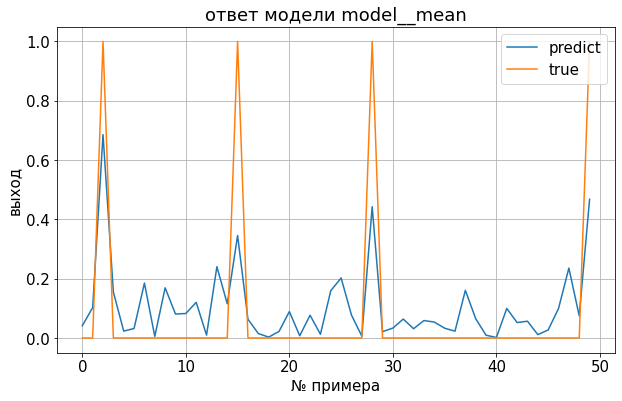

In [312]:
df_mean,pred_mean,best_mean = run_experiment(df_mean_embedding,target, 'model__mean')

Best Threshold=0.29618052251788674, F-Score=0.780, Precision=0.777, Recall=0.784
roc_auc_score: 0.9740961683818827


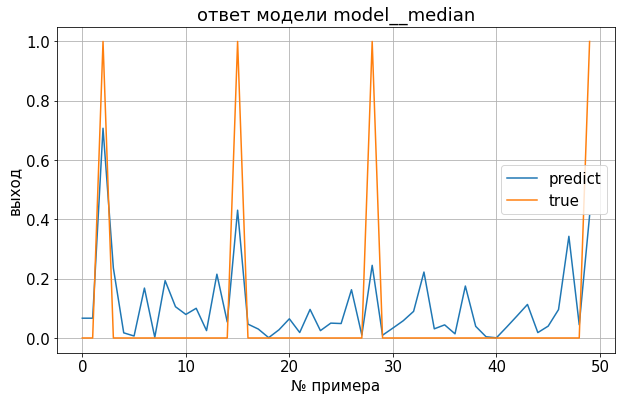

In [314]:
df_median,pred_median,best_median = run_experiment(df_median_embedding ,target, 'model__median')

Best Threshold=0.4716849542917182, F-Score=0.816, Precision=0.893, Recall=0.751
roc_auc_score: 0.9804430490144775


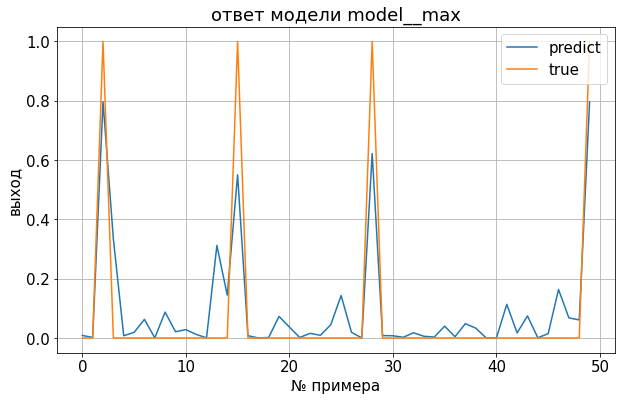

In [313]:
df_max,pred_max,best_max = run_experiment(df_max_embedding ,target, 'model__max')

## **Вывод** 
#### 1.Относительно кол-во проходов, сравним passes=1 и passes=10, при использовании mean

Когда passes=1 Best Threshold=0.22, F-Score=0.656, Precision=0.55, Recall=0.812

Когда passes=10 Best Threshold=0.2960210105377586, F-Score=0.782, Precision=0.780, Recall=0.784
(F-мера и Precision значительно учучшились)

### Сравниваем метрики

In [315]:
def prepeare_score(*best):
    stata = pd.DataFrame()
    
    for i in best:
        a={}
        for key,value in i.items():
            a[key]=value
        stata = stata.append({
                    'model_name': a['model_name'],
                    'Threshold': a['Threshold'],
                    'F-Score': a['F-Score'],
                    'Precision': a['Precision'],
                    'Recall':a['Recall']
                }, ignore_index=True)
    return stata

In [316]:
prepeare_score(best_mean,best_median,best_max)

,model_name,Threshold,F-Score,Precision,Recall
0,model__mean,0.298575,0.797546,0.799180,0.795918
1,model__median,0.296181,0.780488,0.777328,0.783673
2,model__max,0.471685,0.815965,0.893204,0.751020


## **Вывод** 
#### 1.Относительно кол-во проходов c passes=10 оказалось эфективнее. Кол-во проходов, хоть и затратнее по времени, но чем выше тем качественнее.
#### 2. Модель с max, показала наиболее сильные метрики, т.к. показало целевой интерес пользователяк к теме.
